In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
df = pd.read_csv('bank-full.csv', sep=';')

In [14]:
columns = ['age', 'job', 'marital', 'education', 'balance', 'housing', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']

In [15]:
df = df[columns]

In [16]:
df

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,yes,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,29,yes,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,2,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,1506,yes,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,1,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,825,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,1729,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,5715,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,668,no,telephone,17,nov,508,4,-1,0,unknown,no


In [56]:
categorical = ['job', 'marital', 'education', 'balance', 'housing', 'contact', 'month', 'poutcome']
numerical = ['age', 'day', 'duration', 'campaign', 'pdays', 'previous']

len(categorical) + len(numerical)

14

In [17]:
df.isna().sum()

age          0
job          0
marital      0
education    0
balance      0
housing      0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [18]:
# Mode of Education
df.education.mode()

0    secondary
Name: education, dtype: object

In [42]:
string_columns = list(df.dtypes[df.dtypes == 'object'].index)

for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')

In [32]:
df.columns[df.dtypes == 'int64']

Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'], dtype='object')

<Axes: >

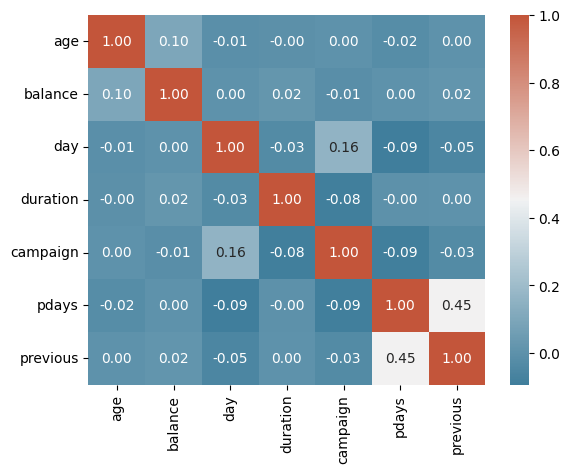

In [41]:
# Correlational Matrics
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(df[df.columns[df.dtypes == 'int64']].corr(), annot=True, cmap=cmap, fmt='.2f')

In [44]:
# Replace y values with binary
df.y = (df.y == 'yes').astype(int)

In [45]:
from sklearn.model_selection import train_test_split

In [46]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_train_full, test_size=0.33, random_state=42)

y_train = df_train.y.values
y_val = df_val.y.values

del df_train['y']
del df_val['y']

#### Mutual Info Score

In [49]:
from sklearn.metrics import mutual_info_score

In [54]:
def calculate_mi(series):
    return round(mutual_info_score(series, df_train_full.y), 2)

df_mi = df_train_full[['contact', 'education', 'housing', 'poutcome']].apply(calculate_mi)
df_mi = df_mi.sort_values(ascending=False).to_frame(name='MI')

df_mi.head()

,MI
poutcome,0.03
contact,0.01
housing,0.01
education,0.00


#### Model Training

In [57]:
from sklearn.feature_extraction import DictVectorizer

In [58]:
train_dict = df_train[categorical + numerical].to_dict(orient='records')

In [59]:
train_dict[0]

{'job': 'admin.',
 'marital': 'single',
 'education': 'secondary',
 'balance': -507,
 'housing': 'yes',
 'contact': 'unknown',
 'month': 'may',
 'poutcome': 'unknown',
 'age': 24,
 'day': 27,
 'duration': 446,
 'campaign': 1,
 'pdays': -1,
 'previous': 0}

In [60]:
dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

DictVectorizer(sparse=False)

In [61]:
X_train = dv.transform(train_dict)

In [62]:
X_train.shape

(24232, 47)

#### Logistic Regression

In [63]:
from sklearn.linear_model import LogisticRegression

In [64]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

In [65]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [66]:
model.predict_proba(X_val)

array([[0.98660694, 0.01339306],
       [0.98986729, 0.01013271],
       [0.83870232, 0.16129768],
       ...,
       [0.99189723, 0.00810277],
       [0.96977596, 0.03022404],
       [0.91315776, 0.08684224]])

In [67]:
y_pred = model.predict_proba(X_val)[:, 1]

In [68]:
churn = y_pred > 0.5

In [82]:
global_accuracy = (y_val == churn).mean()
global_accuracy

np.float64(0.9013907506702413)

In [109]:
def train_validate_accuracy(exclusion = None, C=1.0, print_elim=True, print_acc=True):
    train_dict = df_train[[col for col in (categorical + numerical) if col != exclusion]].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    dv.fit(train_dict)

    X_train = dv.transform(train_dict)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000, random_state=42)
    model.fit(X_train, y_train)

    val_dict = df_val[[col for col in (categorical + numerical) if col != exclusion]].to_dict(orient='records')
    X_val = dv.transform(val_dict)
    
    y_pred = model.predict_proba(X_val)[:, 1]

    churn = y_pred > 0.5
    
    accuracy = (y_val == churn).mean()
    accuracy
    if print_acc == True:
        print(f"C:{C},  Accuracy:{round(accuracy,7)}")
    if print_elim == True:
        print(f"The model with elimination of '{exclusion}' provides {round((accuracy - global_accuracy),6)} difference")

In [105]:
ex = [ 'age', 'balance', 'marital', 'previous']

for exclusion in ex:
    train_validate_accuracy(exclusion, print_acc=False)
    print("======")

The model with elimination of 'age' provides 8.4e-05 difference
The model with elimination of 'balance' provides 0.000168 difference
The model with elimination of 'marital' provides 0.000586 difference
The model with elimination of 'previous' provides 0.000168 difference


In [110]:
c_list = [0.01, 0.1, 1, 10, 100]

for C in c_list:
    train_validate_accuracy(exclusion, C=C, print_elim=False)
    print("======")

C:0.01,  Accuracy:0.8983747
C:0.1,  Accuracy:0.9018097
C:1,  Accuracy:0.9015583
C:10,  Accuracy:0.9017259
C:100,  Accuracy:0.9017259
